<center><b><font size=6>Unsupervised learning – clustering<b><center>

This notebook ...

0. **Install Dependencies**
1. **Determine the Number of Clusters**
2. **Tune Other Hyperparameters**
3. **Visualize the Clusters**
4. **Cluster Analysis**
5. **Assess Homogeneity and Intent Reflection**
6. **Associate Clusters with Specific Attack Categories**

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section3

Installing common packages: pandas, pyarrow
  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
No dependencies found for section 'Section 3'.


In [1]:
!pip install WordCloud

  Using cached wordcloud-1.9.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


In [5]:
!pip install pyarrow

  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

<center><b><font size=5>Determine the Number of Clusters<b><center>

Identify the optimal number of clusters using evaluation methods like the Elbow Method or Silhouette Analysis.

**Steps:**

- Evaluate Data for Clustering
- Apply Clustering Evaluation Techniques
- Decide and Document

### Evaluate Data for Clustering

- Preprocess the text sessions (e.g., tokenize and vectorize using TF-IDF or word embeddings).
- Ensure data is normalized and ready for clustering.

In [6]:
SSH_Attacks = pd.read_parquet("../data/raw/ssh_attacks.parquet")
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


### Apply Clustering Evaluation Techniques

- Use the Elbow Method:
  - Calculate the sum of squared distances (inertia) for a range of cluster numbers.
  - Plot inertia vs. the number of clusters to identify the "elbow" point.
- Use Silhouette Analysis:
  - Compute the silhouette score for each potential cluster number.
  - Plot silhouette scores to find the number with the highest score.

### Decide and Document

- Select the optimal number of clusters based on the evaluation.
- Visualize and explain the reasoning with supporting metrics and charts.

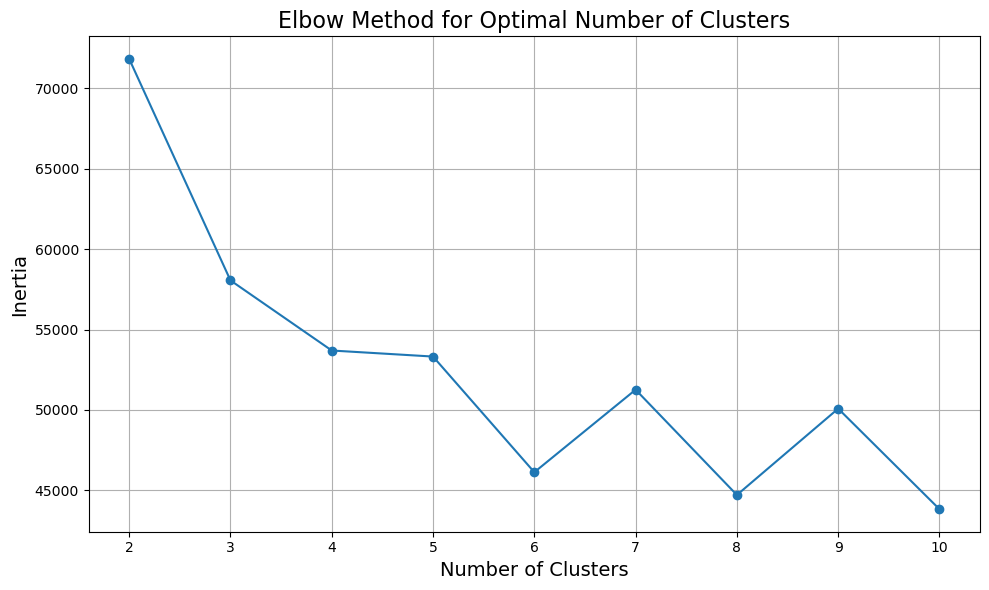

In [7]:
# Step 1: Determine the number of clusters
# Convert full_session to a TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 words for efficiency
X_tfidf = tfidf_vectorizer.fit_transform(SSH_Attacks['full_session'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x)))

# Use the Elbow method to determine the optimal number of clusters
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Silhouette analysis for optimal clusters
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    silhouette_scores.append(silhouette_score(X_tfidf, labels))

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Analysis for Optimal Number of Clusters', fontsize=16)
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Tune hyper-parameters
# Choosing the number of clusters based on the above analysis
optimal_k = 5  # Example, choose the value of k based on elbow and silhouette scores
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_tfidf)


In [ ]:
# Step 3: Visualize clusters using t-SNE
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_tfidf.toarray())  # Reduce dimensionality for efficiency
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette='Set1', legend='full')
plt.title('t-SNE Visualization of Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# Step 4: Cluster Analysis
# Analyze the characteristics of each cluster
for cluster_num in range(optimal_k):
    print(f"\nCluster {cluster_num}:\n")
    cluster_indices = [i for i, label in enumerate(kmeans_labels) if label == cluster_num]
    cluster_sessions = SSH_Attacks.iloc[cluster_indices]
    cluster_words = ' '.join([' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x) for x in cluster_sessions['full_session']])
    wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(cluster_words)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 5: Check if clusters reflect intent division
for cluster_num in range(optimal_k):
    cluster_intents = SSH_Attacks.iloc[[i for i, label in enumerate(kmeans_labels) if label == cluster_num]]['Set_Fingerprint']
    all_intents = [intent for intents in cluster_intents for intent in intents]
    print(f"Cluster {cluster_num} Intent Distribution:")
    print(pd.Series(all_intents).value_counts())
    print("\n")

<center><b><font size=5>Tune Other Hyperparameters<b><center>

Adjust algorithm-specific parameters to improve cluster quality and coherence.

**Steps:**

- Identify Relevant Hyperparameters
- Experiment with Hyperparameters
- Select the Best Configuration

### Identify Relevant Hyperparameters

- Determine parameters to tune for your chosen algorithms:
  - For k-means: `k` (number of clusters), initialization method.
  - For DBSCAN: `ε` (neighborhood radius), `min_samples` (minimum points in a neighborhood).

### Experiment with Hyperparameters

- Use grid search or iterative trials to test different parameter combinations.
- Evaluate cluster quality for each setting using silhouette scores or visual inspection.

### Select the Best Configuration

- Choose the hyperparameters yielding the most coherent clusters.
- Document the results with before-and-after comparisons.

<center><b><font size=5>Visualize the Clusters<b><center>

Use t-SNE or UMAP to create clear visual representations of the clusters.

**Steps:**

- Reduce Dimensionality
- Create Visual Representations
- Analyze and Save

### Reduce Dimensionality

- Apply t-SNE or UMAP to reduce the data to two or three dimensions for visualization.
- Normalize or scale data if required by the algorithm.

### Create Visual Representations

- Plot the data points with cluster assignments using a scatter plot:
  - Assign distinct colors to each cluster.
  - Add legends and labels for clarity.

### Analyze and Save

- Highlight overlaps or ambiguous clusters in the visualization.
- Save the plots and include them in your report for analysis.

<center><b><font size=5>Cluster Analysis<b><center>

Examine and interpret each cluster’s defining characteristics using word clouds and frequent terms.

**Steps:**

- Identify Key Characteristics
- Describe Cluster Patterns
- Document Insights

### Identify Key Characteristics

- Extract the most frequent words or phrases in each cluster.
- Generate word clouds to visually represent the distinctive terms for each cluster.

### Describe Cluster Patterns

- Analyze relationships or patterns among clusters:
  - Are clusters clearly separated or overlapping?
  - What types of terms dominate each cluster?

### Document Insights

- Summarize findings for each cluster with observations about their unique traits.

<center><b><font size=5>Assess Homogeneity and Intent Reflection<b><center>

Evaluate how well clusters align with intents and assess their homogeneity.

**Steps:**

- Match Clusters to Intents
- Analyze Homogeneity
- Draw Conclusions

### Match Clusters to Intents

- Compare each cluster to the dataset’s labeled intents (e.g., Persistence, Discovery, etc.).
- Use metrics like the homogeneity score or manual inspection to evaluate alignment.

### Analyze Homogeneity

- Check if clusters are homogeneous (single intent) or mixed (multiple intents).
- Record insights into intent distribution within clusters.

### Draw Conclusions

- Discuss the implications of the findings:
  - Are clusters meaningful in terms of attack intents?
  - What could improve clustering accuracy?

<center><b><font size=5>Associate Clusters with Specific Attack Categories<b><center>

Analyze selected clusters to identify finer-grained attack categories and unique behaviors.

**Steps:**

- Select Representative Clusters
- Analyze Cluster Contents
- Relate to Practical Scenarios

### Select Representative Clusters

- Choose a few clusters that show interesting or unique behavior for deeper analysis.

### Analyze Cluster Contents

- Examine the sessions in these clusters:
  - Identify patterns or behaviors that distinguish them.
  - Determine subcategories of attacks within these clusters.

### Relate to Practical Scenarios

- Link findings to real-world attack methodologies:
  - Use graph-based techniques or manual inspection for further refinement.
- Present results with examples and interpretations to showcase finer attack categorization.